In [8]:
import numpy as np

# import theano
# import theano.tensor as T
# import theano.tensor.nnet as nnet

import time
import pydot
import graphviz
import cv2 
import math
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal
from math import sqrt
from skimage import transform
import skimage 


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [9]:
def prepImg(fileName, scale):
    img = cv2.imread(fileName, 0)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(img,-1,kernel)
    img_rescaled = get_rescaled(dst, scale)    
    return img_rescaled

def get_rescaled(img, percent):
    width, height = img.shape
    resized = skimage.transform.resize(img, output_shape=[int(width * percent), 
                int(height * percent)], order=1, mode='constant', cval=0, clip=True, preserve_range=False)
    return resized

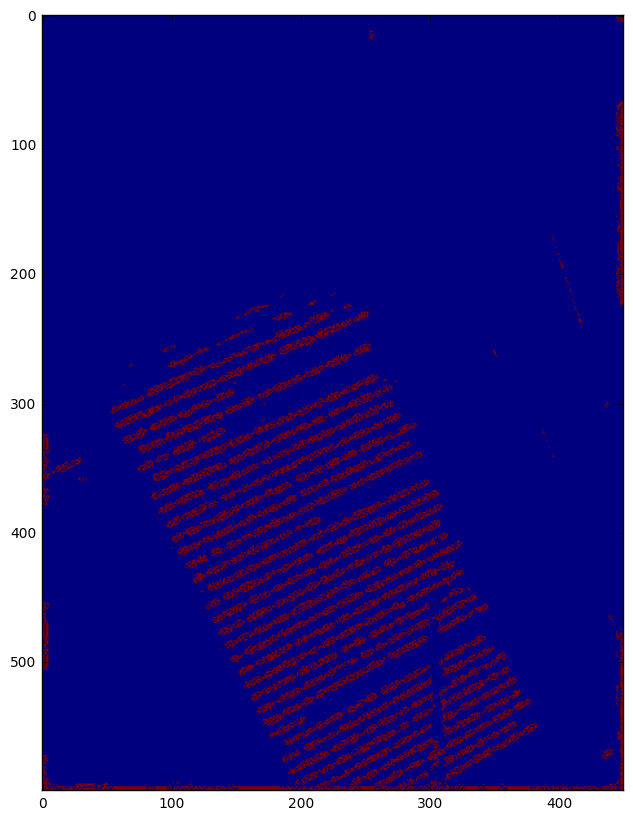

In [10]:
combine = cv2.imread("./training/preprocess/img0_combined.jpg", 0)
combine1 = combine / 255
plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
plt.imshow(combine1)    


In [11]:
ksize = 7
kernel = cv2.getGaussianKernel(ksize, 0.3*((ksize-1)*0.5 - 1) + 0.8)
gaussk = signal.convolve2d(kernel, np.transpose(kernel))

# cutaway borders
border = 10
blurred = signal.convolve2d(combine1, gaussk, 'same')
cut = blurred[border:-border, border:-border]
# plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
# plt.imshow(cut)    


In [158]:
def findLines(maxAngl, minAngl, img):
    maxAngl = np.pi/2 + np.pi/6
    minAngl = np.pi/2 - np.pi/6
    lines = cv2.HoughLines(img, rho = 0.9, theta = np.pi/360, threshold = 100)
    empty = np.ones((600, 450))
    output = np.empty([1, 2])
    for item in lines:
        for rho, theta in item:
            if theta < maxAngl and theta > minAngl:
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))
                cv2.line(empty,(x1,y1),(x2,y2),(1,1,1),1)
                output = np.append(output, np.array([rho, theta]).reshape(1,2), axis=0)

    output = np.reshape(output, (output.shape[0], 1, 2))
    #     return lines
    # assert output[:][0] is rho
    #        output[:][1] is theta
    return output[1:]

#     plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
#     plt.imshow(img)    

# calculate m and b values for lines
# y = mx + b 
# x = p cos(O)
# m = - tan(O)
# b = cos(O)(p + 1/p)




def makeMeans(k, crossings, lines):
    
    L = lines.shape[0]
    minx = np.inf
    maxx = -np.inf
    miny = np.inf
    maxy = -np.inf
    idx = 0

    for i in range(L):
        for j in range(i + 1, L):
            xcross = crossings[idx, 0]
            ycross = crossings[idx, 1]
            if minx > xcross:
                minx = xcross
            if maxx < xcross:
                maxx = xcross
            if miny > ycross:
                miny = ycross
            if maxy < ycross:
                maxy = ycross
            idx += 1
    
    means = np.ndarray([2, k])
    for i in range(k):
        x = np.random.uniform(minx, maxx, size=1)[0]
        y = np.random.uniform(miny, maxy, size=1)[0]    
        means[0][i] = x
        means[1][i] = y
    return means

def makeMeansAroundMean(k, distance, crossings):
    xMean = 0
    yMean = 0
    for idx in range(crossings.shape[0]):
        xMean += crossings[idx][0]
        yMean += crossings[idx][1]
    xMean = xMean/(idx + 1)
    yMean = yMean/(idx + 1)
    
    means = np.ndarray([2, k])
    for idx in range(k):
        angle = np.random.uniform(-np.pi, np.pi, size=1)[0]
        means[0, idx] = xMean + distance * idx * np.cos(angle)
        means[1, idx] = yMean + distance * idx * np.sin(angle)
        
    return means

def calcMandB(lines):
    L = lines.shape[0]
    mb = np.ndarray([L, 2])
    for idx in range(L):
        rho = lines[idx][0][0]
        theta = lines[idx][0][1]
        mb[idx, 0] = -(np.pi/2 - theta)
        mb[idx, 1] = rho*(np.sin(theta) + np.cos(theta)**2/np.sin(theta))
    # assert mb[:,0] is m -- tilt of line
    # assert mb[:,1] is b -- crossing of y-axis
    return mb

def makeCrossings(mb):
    count = 0
    L = mb.shape[0]
    for i in range(L):
        for j in range(i + 1, L):
            count += 1

    crossings = np.ndarray([count, 2])
    idx = 0
    for i in range(L):
        for j in range(i + 1, L):
            # test case
            mb1 = mb[i,:]
            mb2 = mb[j,:]
            # a is tilt of line1
            # c is crossing of y axis line1
            # b is tilt of line2
            # d is crossing of y axis line2            
            a = mb1[0]
            c = mb1[1]
            b = mb2[0]
            d = mb2[1]

            div = a - b if (a - b != 0) else 1
            xcross = (d - c)/div
            ycross = (a * d - b * c)/div            
            crossings[idx, 0] = xcross
            crossings[idx, 1] = ycross
            idx += 1
    # assert: crossings[:, 0] is x coordinate
    #         crossings[:, 1] is y coordinate
    return crossings

def getH(img, vanishing_point):    
    x = vanishing_point[0]
    y = vanishing_point[1]

    img_height, img_width = img.shape
    theta = np.arctan(x/y)

    T1 = np.identity(3)
    T1[0, 2] = -img_width/2
    T1[1, 2] = -img_height/2

    R1 = np.identity(3)
    R1 = np.array([[np.cos(theta), np.sin(theta), 0],
                  [-np.sin(theta), np.cos(theta), 0],
                  [0             , 0            , 1]])

    vp_vect = np.array([x, y, 1]).reshape(3,1)

    vp_vect_rot = np.dot(R1, np.dot(T1, vp_vect))

    K1 = np.identity(3)
    K1[0, 2] = -1/vp_vect_rot[0, 0]

    H = np.linalg.inv(T1).dot(K1.dot(R1.dot(T1)))

    return H[:2, :]



In [227]:
def clusterMeans(k, loops, crossings):

    # k = 20
    # loops = 30

    L = len(crossings)

    crossingsExt = np.tile(crossings, (1, k))
    crossingsExt = np.reshape(crossingsExt, (L, k, 2))

    # means = makeMeans(k, crossings, lines)
    means = makeMeansAroundMean(k, 100, crossings)
    last = np.copy(means)
    newMeans = np.ndarray([2, k])


    for p in range(loops): 
        if p%2 == 0:
            secLast = np.copy(newMeans)        
            means = np.copy(last)
        else:        
            last = np.copy(newMeans)
            means = np.copy(secLast)

        means = np.tile(means, (L, 1))
        meansExt = np.reshape(means, (L, k, 2))
        difference = np.linalg.norm(crossingsExt - meansExt, axis=2)
        print "Clustermean difference:"
        print difference.shape
        minVals = np.min(difference, 1).reshape(L, 1)
        minValsExt = np.tile(minVals, (1, k))
        positions = np.argwhere(difference - minValsExt == 0)[:, 1]
        bins = np.empty([k], dtype=list)
        for i in range(k):
            bins[i] = []
        for i in range(L):
            bins[positions[i]].append(crossings[i])

        newMeans = np.ndarray([2, k])
        for i in range(k):
            if len(bins[i]) == 0:
                newMeans[:, i] = sum(bins[i])
            else:
                something = (np.sum(np.asarray(bins[i]), 0)/len(bins[i]))
                newMeans[:, i] = something  
    return newMeans, bins
#         if (newMeans == last).all() or (newMeans == secLast).all():
#             print "found it at " + str(p) + "th itteration\n"
#             break
#         if p == loops - 3 or p == loops - 2 or p == loops - 1:
#             for i in range(k):
#                 print len(bins[i])
#             print ""

    

(3741, 2)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)
Clustermean difference:
(3741, 20)


In [384]:
def newMakeMeans(k, crossings, dist=10):
    xMean = 0
    yMean = 0
    for idx in range(crossings.shape[0]):
        xMean += crossings[idx][0]
        yMean += crossings[idx][1]
    xMean = xMean/(idx + 1)
    yMean = yMean/(idx + 1)
    means = np.ndarray([k, 2])
    for idx in range(k):
        angle = np.random.uniform(-np.pi, np.pi, size=1)[0]
        means[idx, 0] = xMean + dist * idx * np.cos(angle)
        means[idx, 1] = yMean + dist * idx * np.sin(angle)
    return means
    
def newClustering(k, cross, loops):
    L = cross.shape[0]

    cross_tweaked = np.tile(cross, (1, k))
    cross_tweaked = np.reshape(cross_tweaked, (L, k, 2))

    means = newMakeMeans(k, crossings)
    
    for p in range(loops):
    
        means_tweaked = np.tile(means, (L, 1))
        means_tweaked = np.reshape(means_tweaked, (L, k, 2))
        diff = np.linalg.norm(cross_tweaked - means_tweaked, axis=2)   
        positions = np.argmin(diff, axis=1).reshape(L, 1)
        
        bins = []
        for i in range(k):
            bins.append([])
        for idx in range(L):
            bins[positions[idx]].append(cross[idx])
        means = np.ndarray([k, 2])    
        for i in range(k):
            if len(bins[i]) == 0:
                means[i, :] = np.asarray([0, 0])
            else:                
                means[i, :] = np.sum(np.asarray(bins[i]), axis=0)/len(bins[i])
    return means, bins



In [385]:

k = 20

maxAngl = np.pi/2 + np.pi/6
minAngl = np.pi/2 -np.pi/6

# ------------------------------------------
lines = findLines(maxAngl, minAngl, combine1)
# assert output[:][0] is rho
#        output[:][1] is theta
# print lines[0]
# check, assertion True!
# ------------------------------------------
mb = calcMandB(lines)
# assert mb[:,0] is m -- tilt of line
#        mb[:,1] is b -- crossing of y-axis
# print mb[0]
# check, assertion True!
# ------------------------------------------
crossings = makeCrossings(mb)
# assert: crossings[:, 0] is x coordinate
#         crossings[:, 1] is y coordinate
# print crossings.shape
# this assertion is hard to validate!
# ------------------------------------------
# van_points, bins = clusterMeans(k, 10, crossings)
van_points, bins = newClustering(k, crossings, 10)

(3741, 2)


/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:72: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


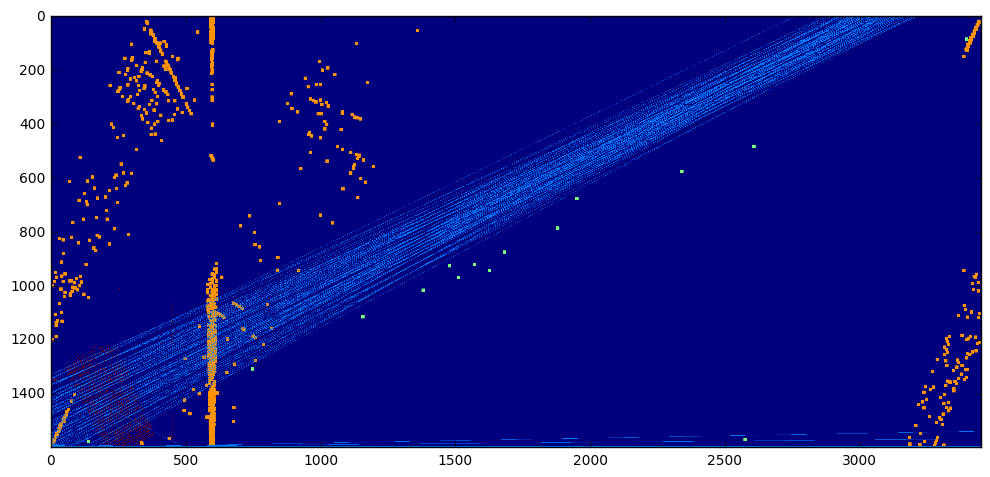

In [417]:
# visualize vanishing points
def showVanPoint(k, img, van_points, cross, lines=[], add_lines=False):

    # extend image
    img_height, img_width = img.shape
    width_ext = 3000
    height_ext = 1000
 
    ext_img = np.append(img, np.zeros([img_height, width_ext]), axis=1)
    ext_img = np.append(np.zeros([height_ext, img_width + width_ext]), ext_img, axis=0)
    rad = 6
    
    for idx in range(L):
        new_x = cross[idx][0]
        new_y = cross[idx][1]
        ext_img[new_x-rad:new_x+rad, new_y-rad:new_y+rad] = 0.75
    
    for i in range(k):
        new_x = van_points[i, 1]
        new_y = van_points[i, 0] - height_ext
        ext_img[new_x-rad:new_x+rad, new_y-rad:new_y+rad] = 0.5
    
    if add_lines:
        for item in lines:
            for rho, theta in item:
                R = height_ext * np.sin(theta) + rho
                if theta < maxAngl and theta > minAngl:
                    a = np.cos(theta)
                    b = np.sin(theta)
                    x0 = a*R
                    y0 = b*R
                    x1 = int(x0 + 10000*(-b))
                    y1 = int(y0 + 10000*(a))
                    x2 = int(x0 - 10000*(-b))
                    y2 = int(y0 - 10000*(a))
                    cv2.line(ext_img,(x1,y1),(x2,y2),(0.25,0.25,0.25),1)

    return ext_img

ext_img = showVanPoint(k, combine1, van_points, crossings, lines, True)

plt.figure(figsize = (12,12))
plt.imshow(ext_img)
    

In [66]:



import cv2 

for i in range(k):
    print len(bins[i])
    h = getH(combine1, newMeans[:, i])
    result = cv2.warpAffine(combine1, h, (img_width, img_height))
#     plt.figure()
#     plt.imshow(result) 
#     plt.title(str(newMeans[:, i]) + "\n" + "i is: " + str(i))

1


NameError: name 'newMeans' is not defined

In [374]:
# print len(bins[14])
# print newMeans[:, 14]
for i in range(k):
    print str(len(bins[i])) + "   " + str(newMeans[:, i])

59   [  6.4711767  -22.08578849]
136   [ 1406.39105576   318.2766803 ]
76   [ 274.84231758    8.11296741]
2   [ -2.38025233e+10   9.99761975e+06]
248   [ 132.04712975 -237.80511688]
105   [-77.57617748 -60.1431288 ]
0   [ 0.  0.]
0   [ 0.  0.]
158   [ 16.20547244 -55.95379454]
674   [-148.02607411    8.23920568]
5   [ 306.49747836 -478.40284983]
534   [ 149.6858223   -28.13980855]
280   [-26.51460986  94.36458401]
36   [ 36563487.21230903  10000003.65634877]
486   [ 105.98722379  -38.14528376]
1   [-241.43414494  192.83136916]
0   [ 0.  0.]
49   [-20365030.5524334    9999997.96349699]
158   [ 152.72144742   26.6833183 ]
821   [ 327.56554669   91.89275697]


(600, 450)


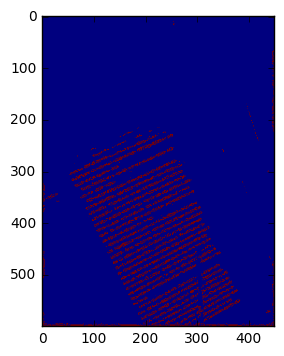

In [375]:
print combine1.shape
plt.imshow(combine1)

/Users/olaroos/virtualenvs/cv/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


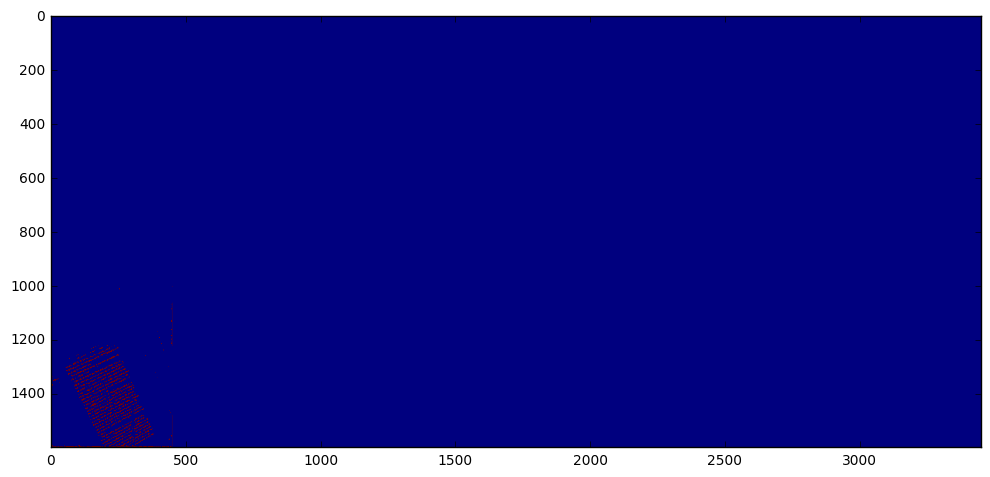

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.]
 [ 1.  0.  1.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  2.]
 [ 2.  0.  2.  0.  0.]]
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


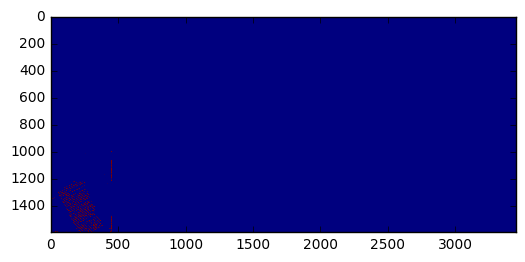

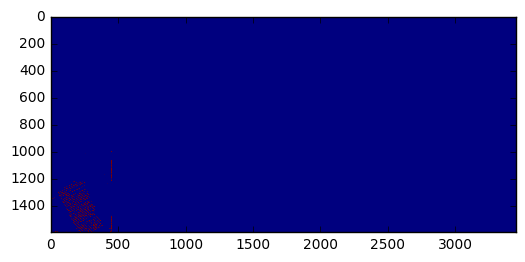

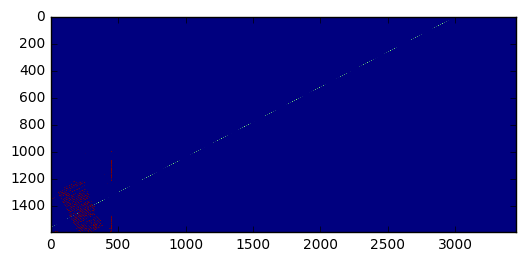

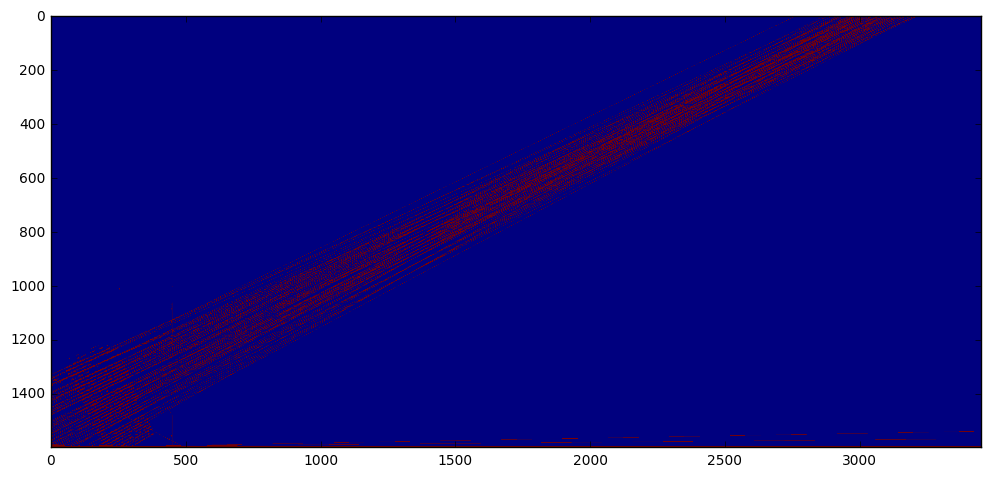

In [377]:
# shift origin of rho and change theta
# this should only be a scaling with reference to the original height and height + height_ext

# r cos(theta) : height = R cos(theta) : height + height_ext
ext_img_cp = np.copy(ext_img)
item = lines[0]
for rho, theta in item:
    R = height_ext * np.sin(theta) + rho
    if theta < maxAngl and theta > minAngl:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*R
        y0 = b*R
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))
plt.figure()
plt.imshow(ext_img_cp)
something = np.copy(ext_img_cp)
cv2.line(ext_img_cp,(x1,y1),(x2,y2),(1,1,1),1)
result = np.add(something,ext_img_cp)
print something[-5:-1,100:105]
print result[-5:-1,100:105]

print type(ext_img_cp)
print type(something)
print type(result)

plt.figure()
plt.imshow(something)
plt.figure()
plt.imshow(result)



for item in lines:
    for rho, theta in item:
        R = height_ext * np.sin(theta) + rho
        if theta < maxAngl and theta > minAngl:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*R
            y0 = b*R
            x1 = int(x0 + 10000*(-b))
            y1 = int(y0 + 10000*(a))
            x2 = int(x0 - 10000*(-b))
            y2 = int(y0 - 10000*(a))
            cv2.line(ext_img_cp,(x1,y1),(x2,y2),(1,1,1),1)

plt.figure(figsize = (12,12))
plt.imshow(ext_img_cp)

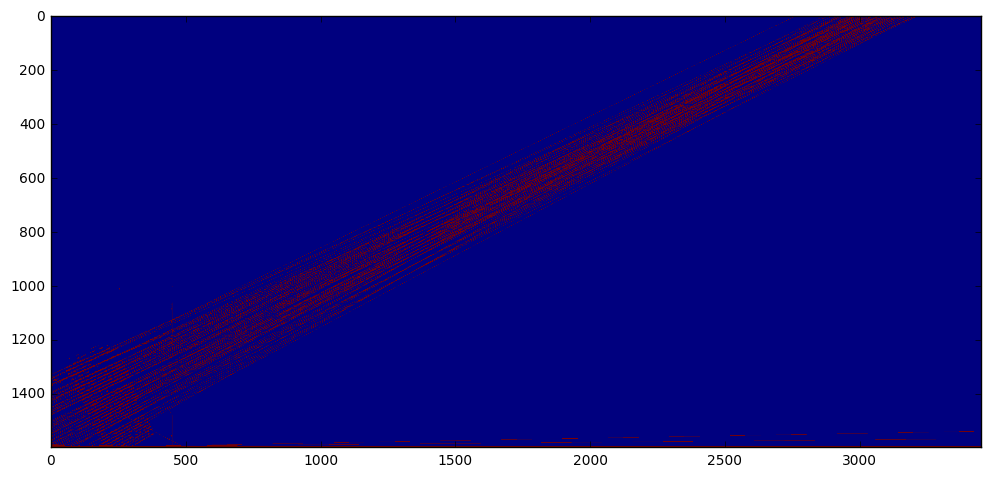

In [378]:
plt.figure(figsize = (12,12))
plt.imshow(ext_img_cp)

In [ ]:
def testCluster():
    L = 3
    k = 3
    d = 3    
    cross = np.array([[3, 4], [7, 10], [10, 13]])    

    tweaked_cross = np.tile(cross, (1, k))
    tweaked_cross = np.reshape(tweaked_cross, (L, k, 2))

    means = np.array([[2, 2],[10, 10],[4, 4]])

    for p in range(2):
        means_tweaked = np.tile(means, (L, 1))
        means_tweaked = np.reshape(means_tweaked, (L, k, 2))

        diff = np.linalg.norm(tweaked_cross - means_tweaked, axis=2)

        positions = np.argmin(diff, axis=1).reshape(L, 1)
    
        bins = []
        for i in range(k):
            bins.append([])

        for idx in range(L):
            bins[positions[idx]].append(cross[idx])

        means = np.ndarray([k, 2])    
        for i in range(k):
            if len(bins[i]) == 0:
                means[i, :] = np.asarray([0, 0])
            else:                
                means[i, :] = np.sum(np.asarray(bins[i]), axis=0)/len(bins[i])
    for i in range(k):
        print len(bins[i])
    print means


